<a href="https://colab.research.google.com/github/joangog/slime/blob/main/doc/notebooks/Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirements Setup

In [ ]:
!git clone https://github.com/joangog/slime.git

fatal: destination path 'slime' already exists and is not an empty directory.


In [ ]:
!pip install '/content/slime'

Processing ./slime
  Preparing metadata (setup.py) ... done
  Created wheel for slime: filename=slime-0.1-py3-none-any.whl size=292593 sha256=35f3609be82390cf9c81e2c96e5098dd9529df42573eded826b8d38acaabd659
  Stored in directory: /tmp/pip-ephem-wheel-cache-hf1zhmxv/wheels/9b/75/5b/fac9c5df9eeea7a76d780065b015816b90fcbe92ded3360a0c
Successfully built slime
  Attempting uninstall: slime
    Found existing installation: slime 0.1
    Uninstalling slime-0.1:
      Successfully uninstalled slime-0.1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import models, transforms, datasets
import cv2
import json
import glob
import skimage

from slime import lime_image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('cuda:', cuda, 'device:', device)

cuda: True device: cuda:0


## Load Dataset

In [ ]:
# Image handling functions

def read_img(file_name):
  img = cv2.imread(file_name)
  if (type(img) is np.ndarray):
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32)
    img = img[:, :, (2, 1, 0)]
  else:
    print('image not found - set your path to the image')
  return img


def preprocess(obs, cuda):

    if cuda:
        torch_device = torch.device('cuda:0')
    else:
        torch_device = torch.device('cpu')

    # Normalise for ImageNet
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    obs = obs / 255
    obs = (obs - mean) / std

    # Format properly
    if obs.ndim == 4:
      obs = np.transpose(obs, (0, 3, 1, 2))
    elif obs.ndim == 3:
      obs = np.transpose(obs, (2, 0, 1))
      obs = np.expand_dims(obs, 0)
    obs = np.array(obs)
    obs_tensor = torch.tensor(obs, dtype=torch.float32, device=torch_device)

    return obs_tensor

In [ ]:
# Load images
imgs = [read_img(img_path) for img_path in glob.glob("/content/gdrive/MyDrive/SLIME/images/husky/*")]
img = read_img('/content/gdrive/MyDrive/SLIME/images/husky/husky_6.jpg')

# Load ImageNet labels
with open('/content/gdrive/MyDrive/SLIME/labels.json') as f:
  label_data = json.load(f)

# Load classifier
model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
model = model.to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 102MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Explanation Generation

In [ ]:
# Helper functions for S-LIME

def predict(input, model, cuda):
  output = model(input)
  output = F.softmax(output, dim=1)
  return output


def vgg19_predict(input):
  input = preprocess(input, cuda)  # cuda from outer scope
  output = predict(input, model, cuda)  # model from outer scope
  output = np.array(output.detach().cpu())
  return output


def explain_top_labels(img_explanations, lime_type):

  if type(img_explanations).__name__ != 'list':  # If not list and just one element, convert to 1-element list
    img_explanations = [img_explanations]

  fig, axs = plt.subplots(len(img_explanations),len(img_explanations[0].score))
  if lime_type == 'lime':
    fig.suptitle('LIME Explanations',  y=0.96, size='xx-large')
  elif lime_type == 'slime':
    fig.suptitle('S-LIME Explanations', y=0.96, size='xx-large')
  fig.set_figheight(3*len(img_explanations))
  fig.set_figwidth(15)

  for i, img_explanation in enumerate(img_explanations):

    print(f'Seed {i+1}:')

    # Sort labels based on score
    topk_labels = sorted(img_explanation.score.items(), key=lambda x:x[1], reverse=True)
    k = len(topk_labels)

    # Get masked image for each label
    masked_imgs = []
    for j in range(0,k):
      img, mask = img_explanation.get_image_and_mask(topk_labels[j][0])
      mask = np.expand_dims(mask, axis=-1).repeat(3, axis=-1) == 1
      masked_img = np.full(img.shape, (234,249,255))
      masked_img[mask] = img[mask]
      masked_imgs.append(masked_img)

    print(f'   Top-{k} Labels Predicted:')
    for l, label in enumerate(topk_labels):
      print(f'      {l+1}th Class: "{label_data[str(label[0])][1]}", Score: {round(label[1],2)}')
    print()


    # Plot the masked images for each label and for each explanation

    for j in range(0,k):
      if len(img_explanations) == 1:
        axs_i = axs
      else:
        axs_i = axs[i]

      axs_i[0].text(-25, 90, f'Seed {i+1}', rotation='vertical', va='center')
      axs_i[j].imshow(masked_imgs[j] / 255)
      axs_i[j].set_title(f'#{j+1} : "{label_data[str(topk_labels[j][0])][1]}"')
      axs_i[j].axis('off')
      axs_i[j].spines['top'].set_visible(True)
      axs_i[j].spines['bottom'].set_visible(True)
      axs_i[j].spines['left'].set_visible(True)
      axs_i[j].spines['right'].set_visible(True)

  # Plot the original image and the segments (only once, from the first seed)
  fig_, axs_ = plt.subplots(1,2)
  fig_.set_figheight(3)
  fig_.set_figwidth(6)
  axs_[0].set_title('Original')
  axs_[0].imshow(img / 255)
  axs_[1].set_title('Features (Superpixels)')
  axs_[1].imshow(skimage.segmentation.mark_boundaries(img/255, img_explanations[0].segments))

  for j in [0,1]:
    axs_[j].axis('off')
    axs_[j].spines['top'].set_visible(True)
    axs_[j].spines['bottom'].set_visible(True)
    axs_[j].spines['left'].set_visible(True)
    axs_[j].spines['right'].set_visible(True)


def calculate_jaccard(num_seeds, num_iter, top_labels, top_features, imgs, explainer, labal_data, lime_type, num_samples):

  result = np.zeros((top_labels,num_seeds,num_iter,top_features))
  jaccard = np.zeros((top_labels, num_seeds, top_features))

  for seed in range(num_seeds):

    np.random.seed(seed + 1)

    i = np.random.randint(0, len(imgs))  # We randomly select an image in every seed (Maybe fix?)

    for iter in range(num_iter):
      print(f'Seed {seed + 1} (Image {i}), Iteration {iter}')
      if lime_type == 'lime':
        exp = explainer.explain_instance(imgs[i], vgg19_predict, num_features=top_features, num_samples=num_samples, random_seed=seed)
      elif  lime_type == 'slime':
        exp = explainer.slime(imgs[i], vgg19_predict, num_features=top_features, num_samples=num_samples, random_seed=seed)
      topk_labels_scores = sorted(exp.score.items(), key=lambda x:x[1], reverse=True)
      for topk in range(top_labels):
        topk_label = topk_labels_scores[topk][0]
        result[topk,seed,iter,:] = [i[0] for i in exp.local_exp[topk_label]]

    for topk in range(top_labels):
      for num in range(0, top_features):
          temp = []
          for j in range(num_iter - 1):
              for k in range(j + 1, num_iter):
                A = result[topk,seed,j,:num+1]
                B = result[topk,seed,k,:num+1]
                temp.append(len(set(A).intersection(set(B))) / float(len(set(A).union(set(B)))))
          jaccard[topk,seed,num] = np.mean(temp)

  jaccard = np.mean(jaccard, axis = 1)

  print()
  for k_l in range(1,6):
    print(f'{k_l}th Predicted Class:')
    for k_f in range(1,6):
      print(f'   Using Top-{k_f} Features: {round(jaccard[k_l-1,k_f-1],2)}')

  return jaccard

### Hyperparameters

In [ ]:
# Hyperparameters

num_samples = 150  # Number of samples to take around each data point
top_features = 70   # Top-k superpixels in explanation
top_labels = 5  # Top-k labels to produce explanations for

# For Jaccard experiment
num_seeds = 3
num_iter = 3

### LIME results

Seed 1:


  0%|          | 0/150 [00:00<?, ?it/s]

Seed 2:


  0%|          | 0/150 [00:00<?, ?it/s]

Seed 3:


  0%|          | 0/150 [00:00<?, ?it/s]

Seed 1:
   Top-5 Labels Predicted:
      1th Class: "Siberian_husky", Score: 0.96
      2th Class: "dogsled", Score: 0.91
      3th Class: "malamute", Score: 0.9
      4th Class: "Norwegian_elkhound", Score: 0.86
      5th Class: "Eskimo_dog", Score: 0.86

Seed 2:
   Top-5 Labels Predicted:
      1th Class: "Siberian_husky", Score: 0.96
      2th Class: "malamute", Score: 0.9
      3th Class: "dogsled", Score: 0.83
      4th Class: "Eskimo_dog", Score: 0.76
      5th Class: "Norwegian_elkhound", Score: 0.75

Seed 3:
   Top-5 Labels Predicted:
      1th Class: "Siberian_husky", Score: 0.96
      2th Class: "malamute", Score: 0.9
      3th Class: "dogsled", Score: 0.88
      4th Class: "Eskimo_dog", Score: 0.84
      5th Class: "Norwegian_elkhound", Score: 0.83



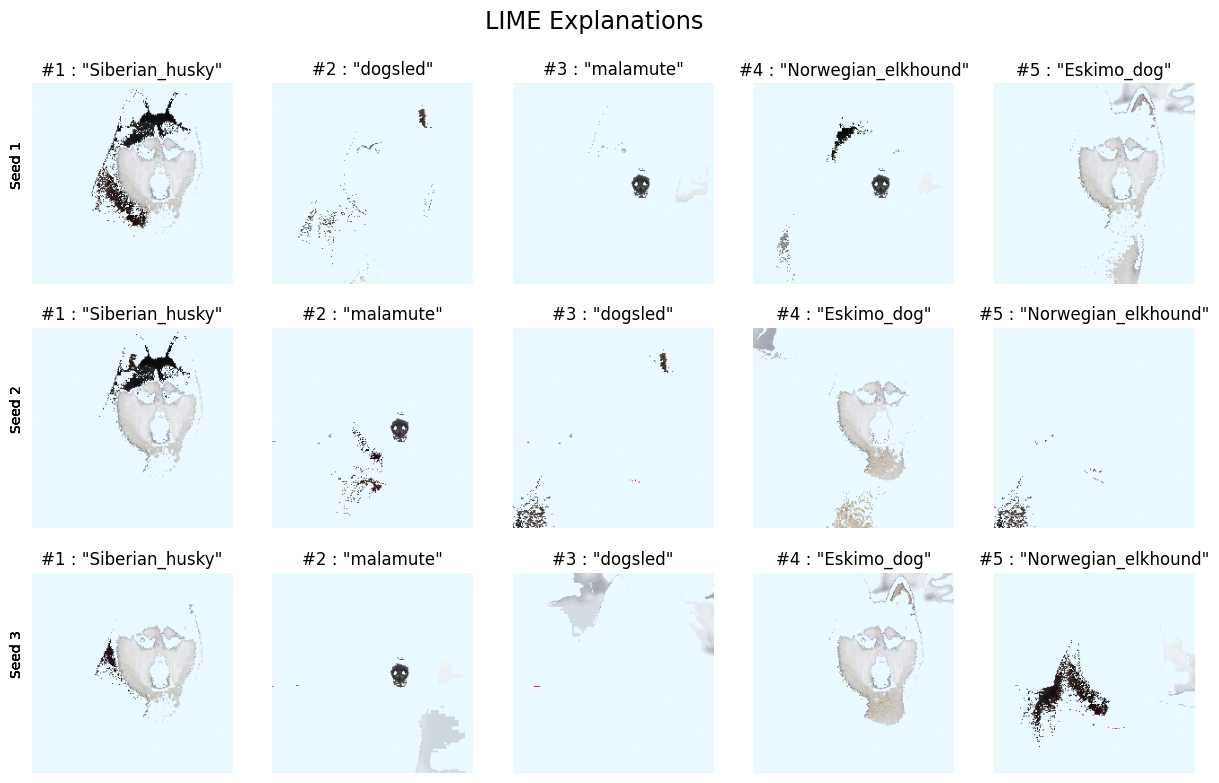

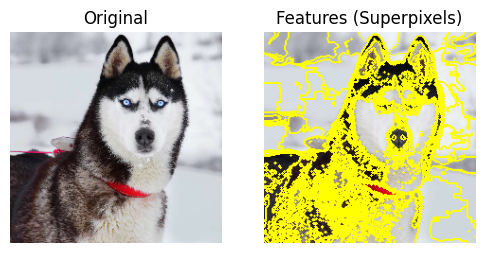

In [ ]:
seeds = [1,2,3]
explanations_lime = []

explainer = lime_image.LimeImageExplainer(feature_selection = "lasso_path")

for seed in seeds:
  print(f'Seed {seed}:')
  np.random.seed(seed)
  explanations_lime.append(explainer.explain_instance(img, vgg19_predict, labels=tuple([i for i in range(top_labels)]), top_labels=top_labels, num_features = top_features, num_samples = num_samples, random_seed=seed))
explain_top_labels(explanations_lime, 'lime')

### S-LIME provides stable explantions

Seed 1:


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/4800 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

Seed 2:


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/4800 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

Seed 3:


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/4800 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

Seed 1:
   Top-5 Labels Predicted:
      1th Class: "Siberian_husky", Score: 0.85
      2th Class: "malamute", Score: 0.62
      3th Class: "dogsled", Score: 0.57
      4th Class: "Eskimo_dog", Score: 0.45
      5th Class: "Norwegian_elkhound", Score: 0.35

Seed 2:
   Top-5 Labels Predicted:
      1th Class: "Siberian_husky", Score: 0.87
      2th Class: "malamute", Score: 0.62
      3th Class: "dogsled", Score: 0.55
      4th Class: "Eskimo_dog", Score: 0.42
      5th Class: "Norwegian_elkhound", Score: 0.33

Seed 3:
   Top-5 Labels Predicted:
      1th Class: "Siberian_husky", Score: 0.86
      2th Class: "malamute", Score: 0.61
      3th Class: "dogsled", Score: 0.56
      4th Class: "Eskimo_dog", Score: 0.45
      5th Class: "Norwegian_elkhound", Score: 0.34



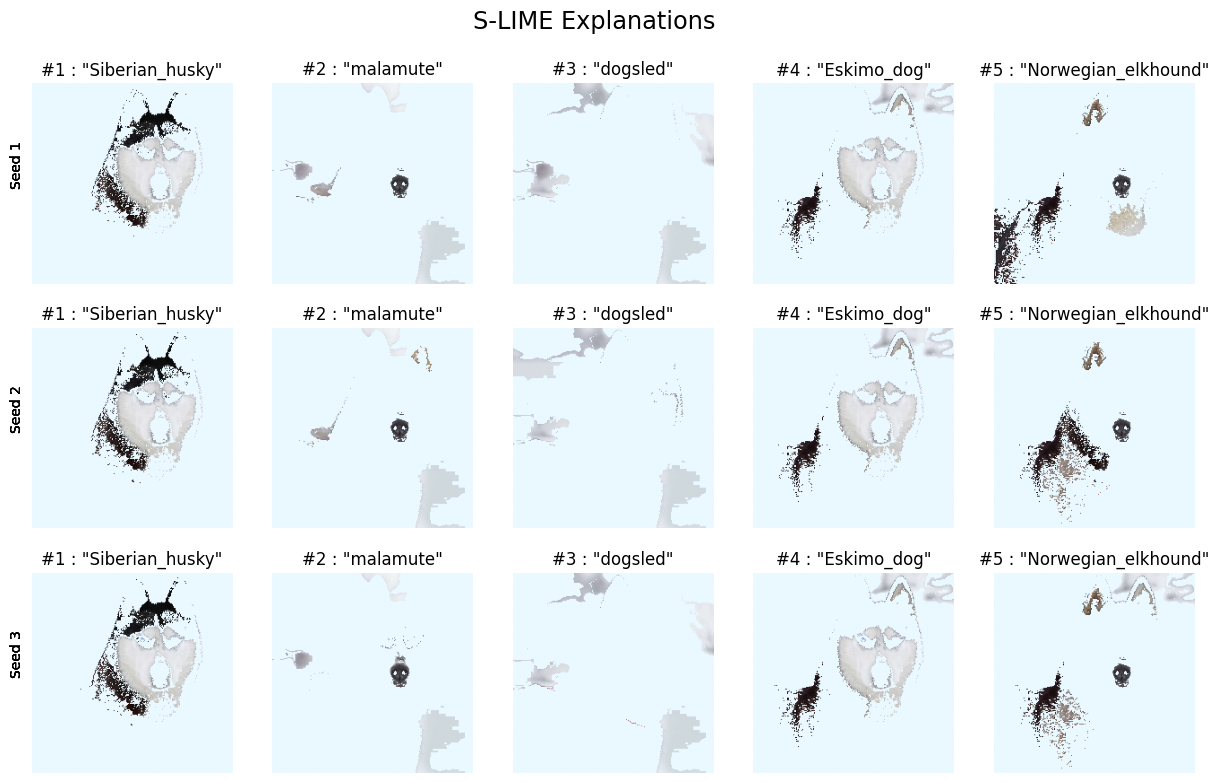

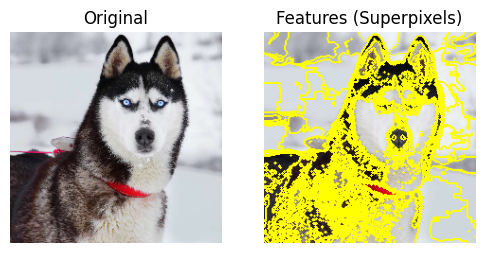

In [ ]:
seeds = [1,2,3]
explanations_slime = []

explainer = lime_image.LimeImageExplainer(feature_selection = "lasso_path")

for seed in seeds:
  print(f'Seed {seed}:')
  np.random.seed(seed)
  explanations_slime.append(explainer.slime(img, vgg19_predict, labels=tuple([i for i in range(top_labels)]), top_labels=top_labels, num_features = top_features, num_samples = num_samples, random_seed=seed))
explain_top_labels(explanations_slime, 'slime')

### Jaccard index for LIME

In [ ]:
# For num_samples = 150

explainer = lime_image.LimeImageExplainer(feature_selection = "lasso_path")
jaccard_lime = calculate_jaccard(num_seeds, num_iter, top_labels, top_features, imgs, explainer, label_data, lime_type='lime', num_samples=num_samples)

Seed 1 (Image 5), Iteration 0


  0%|          | 0/150 [00:00<?, ?it/s]

Seed 1 (Image 5), Iteration 1


  0%|          | 0/150 [00:00<?, ?it/s]

Seed 1 (Image 5), Iteration 2


  0%|          | 0/150 [00:00<?, ?it/s]

Seed 2 (Image 0), Iteration 0


  0%|          | 0/150 [00:00<?, ?it/s]

Seed 2 (Image 0), Iteration 1


  0%|          | 0/150 [00:00<?, ?it/s]

Seed 2 (Image 0), Iteration 2


  0%|          | 0/150 [00:00<?, ?it/s]

Seed 3 (Image 2), Iteration 0


  0%|          | 0/150 [00:00<?, ?it/s]

Seed 3 (Image 2), Iteration 1


  0%|          | 0/150 [00:00<?, ?it/s]

Seed 3 (Image 2), Iteration 2


  0%|          | 0/150 [00:00<?, ?it/s]


1th Predicted Class:
   Using Top-1 Features: 0.67
   Using Top-2 Features: 0.56
   Using Top-3 Features: 0.51
   Using Top-4 Features: 0.41
   Using Top-5 Features: 0.4
2th Predicted Class:
   Using Top-1 Features: 0.33
   Using Top-2 Features: 0.48
   Using Top-3 Features: 0.4
   Using Top-4 Features: 0.36
   Using Top-5 Features: 0.34
3th Predicted Class:
   Using Top-1 Features: 0.33
   Using Top-2 Features: 0.48
   Using Top-3 Features: 0.31
   Using Top-4 Features: 0.28
   Using Top-5 Features: 0.31
4th Predicted Class:
   Using Top-1 Features: 0.11
   Using Top-2 Features: 0.48
   Using Top-3 Features: 0.42
   Using Top-4 Features: 0.35
   Using Top-5 Features: 0.38
5th Predicted Class:
   Using Top-1 Features: 0.56
   Using Top-2 Features: 0.63
   Using Top-3 Features: 0.37
   Using Top-4 Features: 0.25
   Using Top-5 Features: 0.21


In [ ]:
# For num_samples = 9600

explainer = lime_image.LimeImageExplainer(feature_selection = "lasso_path")

jaccard_lime_9600 = calculate_jaccard(num_seeds, num_iter, top_labels, top_features, imgs, explainer, label_data, lime_type='lime', num_samples=9600)

Seed 1 (Image 5), Iteration 0


  0%|          | 0/9600 [00:00<?, ?it/s]

Seed 1 (Image 5), Iteration 1


  0%|          | 0/9600 [00:00<?, ?it/s]

Seed 1 (Image 5), Iteration 2


  0%|          | 0/9600 [00:00<?, ?it/s]

Seed 2 (Image 0), Iteration 0


  0%|          | 0/9600 [00:00<?, ?it/s]

Seed 2 (Image 0), Iteration 1


  0%|          | 0/9600 [00:00<?, ?it/s]

Seed 2 (Image 0), Iteration 2


  0%|          | 0/9600 [00:00<?, ?it/s]

Seed 3 (Image 2), Iteration 0


  0%|          | 0/9600 [00:00<?, ?it/s]

Seed 3 (Image 2), Iteration 1


  0%|          | 0/9600 [00:00<?, ?it/s]

Seed 3 (Image 2), Iteration 2


  0%|          | 0/9600 [00:00<?, ?it/s]


1th Predicted Class:
   Using Top-1 Features: 1.0
   Using Top-2 Features: 1.0
   Using Top-3 Features: 1.0
   Using Top-4 Features: 1.0
   Using Top-5 Features: 0.85
2th Predicted Class:
   Using Top-1 Features: 0.78
   Using Top-2 Features: 1.0
   Using Top-3 Features: 1.0
   Using Top-4 Features: 1.0
   Using Top-5 Features: 0.85
3th Predicted Class:
   Using Top-1 Features: 1.0
   Using Top-2 Features: 1.0
   Using Top-3 Features: 1.0
   Using Top-4 Features: 0.82
   Using Top-5 Features: 1.0
4th Predicted Class:
   Using Top-1 Features: 0.78
   Using Top-2 Features: 1.0
   Using Top-3 Features: 0.89
   Using Top-4 Features: 0.78
   Using Top-5 Features: 0.84
5th Predicted Class:
   Using Top-1 Features: 1.0
   Using Top-2 Features: 1.0
   Using Top-3 Features: 1.0
   Using Top-4 Features: 1.0
   Using Top-5 Features: 0.93


### Jaccard index for S-LIME

In [ ]:
explainer = lime_image.LimeImageExplainer(feature_selection = "lasso_path")

jaccard_slime = calculate_jaccard(num_seeds, num_iter, top_labels, top_features, imgs, explainer, label_data, lime_type='slime', num_samples=num_samples)